<a href="https://colab.research.google.com/github/frank-895/machine_learning_journey/blob/main/image_classification/estonian_mushroom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -q kaggle

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from fastai.vision.all import *

# Image Multiclass Classification

We will be entering this [Kaggle competition](https://www.kaggle.com/competitions/mushroom-multiclass-classification), which is a multiclass image classification project on Estonian mushrooms. The aim is to predict the type of mushroom to improve public safety and knowledge.

I will be taking an iterative approach with this project and I intend on trying a few different models to put forward multiple submissions. We're going to be using the following paradigm with our approach:

1. Create an effective validation set.
2. Iterate rapidly to find changes which improve results on the validation set.

The test set is a random selection of images, so an effective validation set for this project will just be a random selection of the images. Nice and easy!

## Data Extraction

Because we're working with a large image dataset that's too large to manually upload, I'm going to use the command line to manually download the dataset using the Kaggle API.

First, I need to store my Kaggle API credentials as a secret called `'KAGGLE_JSON'` which we can access using `userdata`. This will return the string which we can pass with `json.loads` and store into `os.environ` variables.

This will give our notebook access to the Kaggle competitions I have signed up for. If trying to use this notebook, make sure you follow similar steps:
1. Set secret in Google Colab with Kaggle API credentials.
2. Agree to competition rules for the mushroom classification competition ([Kaggle competition](https://www.kaggle.com/competitions/mushroom-multiclass-classification))

In [4]:
import os, json
from google.colab import userdata

kaggle_json = json.loads(userdata.get('KAGGLE_JSON'))
os.environ["KAGGLE_USERNAME"] = kaggle_json["username"]
os.environ["KAGGLE_KEY"] = kaggle_json["key"]

In [5]:
!kaggle competitions download -c mushroom-multiclass-classification

 95% 31.0M/32.5M [00:00<00:00, 46.6MB/s]
100% 32.5M/32.5M [00:00<00:00, 43.0MB/s]


Now, we can unzip the file to access our dataset.

In [6]:
import zipfile

comp = 'mushroom-multiclass-classification'
with zipfile.ZipFile(f'{comp}.zip', 'r') as zip_ref:
    zip_ref.extractall(comp)

Upon inspection of the files, it appears that we have a bunch of images in a folder called `dataset`, then a `test.csv` and a `train.csv` file.

Let's inspect our csv files closer using pandas, the best library when working with csvs.

In [7]:
import pandas as pd

df = pd.read_csv(f'{comp}/train.csv')
df_test = pd.read_csv(f'{comp}/test.csv')


In [8]:
df_test.head()

,Image
0,2372
1,2373
2,2374
3,2375
4,2376


In [9]:
df.head()

,Image,Mushroom
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


So, it seems that the CSV files specify which images are for training (as they have labels) and which images are for testing (to upload to Kaggle).

Now is a good time to introduce the information about the data. The mushrooms are labelled 0-9 and each number corresponds to the following mushroom type:

0. amanita
1. boletus
2. chantelle
3. deterrimus
4. rufus
5. torminosus
6. aurantiacum
7. procera
8. involutus
9. russula

We have 300 images for each category - 3000 images in total.

We need the `'Image'` column in dataframe to have the same format as the filenames. Since the filenames are in the format 00001.jpg, 00002.jpg, where the number is 5 digits long and padded with zeros, I will alter the dataframe to be the same.

This will enable the dataloaders to correctly classify the images for training.

In [10]:
df['Image'] = df['Image'].apply(lambda x: f"{int(x):05d}.jpg")
df_test["Image"] = df_test['Image'].apply(lambda x: f"{int(x):05d}.jpg")

I will also quickly check that we have no missing values in our dataframe - which we don't :)

In [11]:
df.isnull().sum()

,0
Image,0
Mushroom,0


I'm going to move all the training images into one folder called `'train_images'` and all the test images into a different folder called '`test_images'`. This will make it easy to use FastAI and rapidly iterate.

In [12]:
import shutil

# define paths
image_folder = comp + "/dataset/dataset/"
train_folder = comp + "/dataset/train_images/"
test_folder = comp + "/dataset/test_images/"

# make folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# convert to lists with zero-padded filenames (this is how they are named)
train_images = df["Image"]
test_images = df_test["Image"]

# move images into respective folders
for img in train_images:
  src = os.path.join(image_folder, img)
  dst = os.path.join(train_folder, img)
  if os.path.exists(src):
    shutil.move(src, dst)

for img in test_images:
  src = os.path.join(image_folder, img)
  dst = os.path.join(test_folder, img)
  if os.path.exists(src):
    shutil.move(src, dst)

Let's inspect our images.

**Important note**: generally, when working with image libraries, including Pillow, images are measured columns by rows (the opposite of dataframes in Pandas or tensors in PyTorch).

(259, 194)


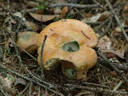

In [13]:
files = get_image_files(train_folder)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like we're probably working with images of all different sizes. But we can use fastcore's `parallel` library to quickly find the size of all our images.

In [14]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

,count
"(259, 194)",457
"(275, 183)",446
"(225, 225)",170
"(194, 259)",104
"(183, 275)",59
...,...
"(372, 135)",1
"(179, 281)",1
"(287, 176)",1
"(246, 204)",1


As expected, we have 262 different image sizes. This will be important to take into account when creating our Dataloaders.

## Baseline Model

We're going to start with a very easy and quick model using FastAI - this will give us an indication of how much our more advanced techniques help us out.

For now, we will transform our individual images into a square of 280px by 280px and **squish** them to meet this ratio. This is default behaviour when you have a variety of image sizes. This will mean they have a uniform size before being passed to the GPU, allowing them to be batched together for data augmentation.

We will also perform data augmentation using FastAI's `aug_transforms()` function, passing it to `batch_tfms` which will apply the augmentation to the entire batch of images at once. This operation is done on the GPU. `aug_transforms` will take a random 75% of the image, resizing it even smaller to increase speed.

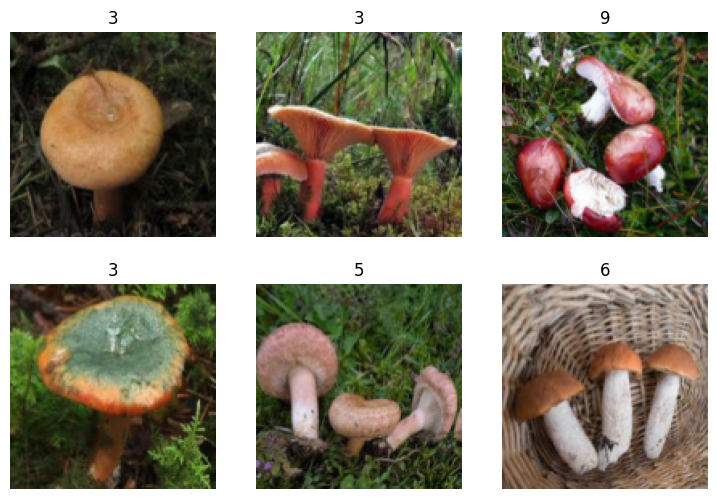

In [15]:
dls = ImageDataLoaders.from_df(
    df,
    path=train_folder,
    folder='',
    valid_pct=0.2,
    item_tfms=Resize(280, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)
dls.show_batch(max_n=6)

We're going to start with `resnet26d`, which I picked using this [Kaggle notebook](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). It's got decent accuracy but its also one of the faster models, which is critical for rapid iteration.

By converting to **half-precision floating point** (FP16) with `to_fp16()` we can use half the memory, allowing larger batch sizes and faster training. It should preserve enough precision, but it is a slight trade-off for speed. We use the `path` parameter to specify the directory where FastAI stores temporary files and the model (if we choose to save it).

We use `lr_find()` which helps us to pick a suitable learning rate. We will pick a learning rate that is a little less conservative then the recommendations made.

In [16]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0008317637839354575, slide=0.0014454397605732083)

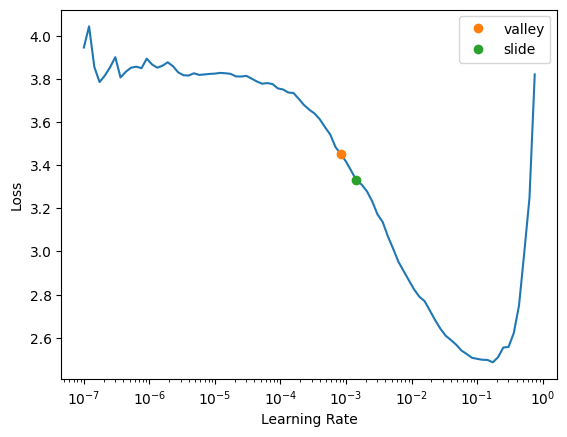

In [17]:
learn.lr_find(suggest_funcs=(valley, slide))

In [18]:
learn.fine_tune(8, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,2.113685,1.504807,0.372093,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.017198,1.100622,0.329810,00:10
1,0.876558,1.055174,0.312896,00:10
2,0.748388,0.959758,0.270613,00:08
3,0.609010,0.920855,0.238901,00:10
4,0.493954,0.814245,0.217759,00:12
5,0.376060,0.809555,0.234672,00:11
6,0.297865,0.814520,0.230444,00:08
7,0.237080,0.808780,0.224101,00:10


Now that we have trained our baseline model, let's submit our predictions to Kaggle.

First, we need to check the format using the sample submission.

In [19]:
pd.read_csv(comp + '/sample_submission.csv').head()

,Id,Predicted
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


We can make our predictions and submit to Kaggle, following the formatting above.

We want a dataloader that is exactly like the dataloader we used to train the model, except pointing at the test set. It will use exactly the same transformations. For this, we use the `test_dl()` function from FastAI, which has a key difference to a normal dataloaders - it doesn't contain any labels.

The `with_decoded` parameter will return not only the logit for each image, but also calculate the index of the most likely. The `_` represents the targets, which are empty since we are using a test set.



In [20]:
test_files = sorted(get_image_files(test_folder))
test_dl = dls.test_dl(test_files)
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [21]:
sub_df = pd.DataFrame({'Predicted':idxs})
sub_df['Id'] = range(0, len(sub_df))
sub_df = sub_df[['Id', 'Predicted']]

In [22]:
sub_df.head()

,Id,Predicted
0,0,8
1,1,5
2,2,2
3,3,7
4,4,4


In [23]:
sub_df.to_csv('subm.csv', index=False)

Our baseline model has an accuracy of 0.82 on the test set, which is pretty good, but puts us towards the bottom of the leaderboard. We will need to improve it to score higher.

## Improving Speed of Iteration

Because we are taking an **iterative approach** to deep learning we want to speed up our process. This means encapsulating some of our code.

We will create 2 functions:
- `train()` to train the model, where we can specify the most important parameters and use default behaviour for the rest.
- `csv()` to create a csv file that we can submit, to see how our performance is.

Our dataloaders object in the `train()` function is much the same, except we will make `batch_tfms` and `item_tfms` alterable, so that we can try out different techniques.

We can also easily change the architecture with the `arch` argument as well as the most critical hyperparameters `epoch` and `lr`.

In [24]:
def train(arch, item, batch, epochs=8, lr=0.01):
  dls = ImageDataLoaders.from_df(
    df,
    path=train_folder,
    folder='',
    valid_pct=0.2,
    item_tfms=item,
    batch_tfms=batch
  )
  learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
  learn.fine_tune(epochs, lr)
  return learn

The first model we will train is a slightly larger model that still has good performance, but improved accuracy from the `convnext` family.

In [25]:
learn = train('convnext_small_in22k',
              item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75),
              lr=0.001
)

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.084695,0.519057,0.156448,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.745134,0.472373,0.137421,00:14
1,0.680052,0.432229,0.118393,00:11
2,0.578552,0.402868,0.116279,00:10
3,0.495943,0.373504,0.107822,00:09
4,0.421675,0.372169,0.109937,00:11
5,0.367132,0.364579,0.105708,00:11
6,0.309561,0.359278,0.103594,00:10
7,0.283759,0.359368,0.099366,00:09


We're also going to create a function that can create our csv file.

In [26]:
def csv(idxs):
  sub_df = pd.DataFrame({'Predicted':idxs})
  sub_df['Id'] = range(0, len(sub_df))
  sub_df = sub_df[['Id', 'Predicted']]
  sub_df.to_csv('new_subm.csv', index=False)
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)
csv(idxs)

Bam - just like that, improving the architecture only slightly, with barely an increase in training speed **our score is 0.91 which puts us third in the leaderboard!**

Part of the reason that we didn't see an increase in training speed is because our GPU is being underworked while our CPU is the bottleneck, trying to process all images to make them the same size for the GPU.

## Experiments

So far, we've made two models with different architectures. For the following experiments I'm going to use convnext as this gave us the best result with a negligable increase in training speed.

### Squishing vs Cropping vs Padding

Instead of **cropping** the images, which is FastAI's default for the `Resize()` function, I'm going to specify **padding** as our `method`. This means we won't lose any information, but we will be training a lot of black padding (which is a slight waste of resources).

Let's see if this gives us an improvement compared to before. All other factors are the same, other than random variation!

It's worth noting that our first model we specified **squish** as the method, so now we've actually trialled all ways of resizing our images. With crop we lose data and with squish we distort it, so padding is often the best option.

In [27]:
learn = train('convnext_small_in22k',
              Resize(192, method='padding'),
              aug_transforms(size=128, min_scale=0.75),
              lr=0.001
)

epoch,train_loss,valid_loss,error_rate,time
0,2.087965,0.562812,0.160677,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.680294,0.516634,0.141649,00:11
1,0.635852,0.442584,0.124736,00:11
2,0.525751,0.437432,0.124736,00:10
3,0.443809,0.394371,0.095137,00:10
4,0.372762,0.378605,0.105708,00:11
5,0.325068,0.391143,0.103594,00:10
6,0.294327,0.380412,0.105708,00:10
7,0.258352,0.378733,0.101480,00:11


In [28]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)
csv(idxs)

Another notable improvement! After submitting to Kaggle, **our score is 0.913**, an improvement from 0.91. However, we're still third place on the leaderboard!

### Test Time Augmentation

As defined in the [FastAI textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527), test time augmentation (TTA) is:

> "During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image."

When we train the model, we use augmentation so that the training images look slightly different (warped, cropped, colour change, flipped) each time the model sees it.

This is pictured below:

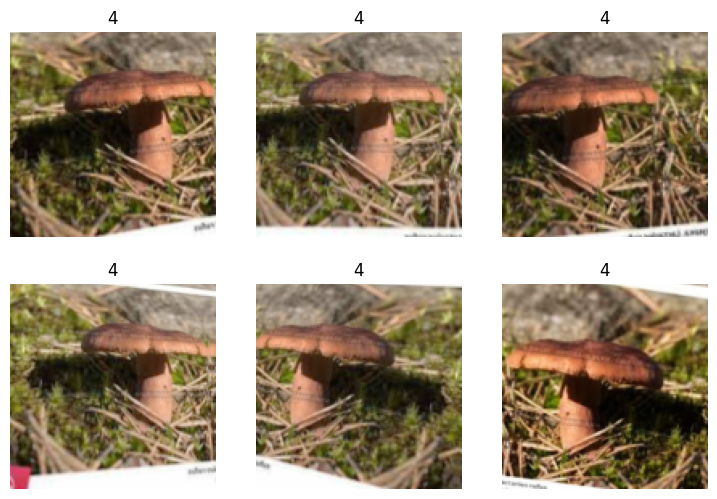

In [29]:
learn.dls.train.show_batch(max_n=6, unique=True)

When we generate our predictions, we can do the same thing, giving the model the augmentation that it used in training. The model will generate a prediction for each version of the image. Then, we take the most common prediction that is generated, improving our predictions even further.

FastAI defines a really convenient `tta()` function to do all this for us. We will test it out on the validation set to see if it works for our data type.

First, let's check the error rate of our validation set as the model stands.

In [30]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.1015)

Now, let's apply TTA.

In [31]:
tta_preds,_ = learn.tta(dl=valid)

In [32]:
error_rate(tta_preds, targs)

TensorBase(0.0951)

And there we go! We got a little improvment boost. This might be just the little boost we need to move up the leaderboard from position 3, as we are close behind the two top submissions!

Let's perform TTA on the predictions and make a new submission!

In [33]:
preds = learn.tta(dl=test_dl)[0].argmax(dim=1)

In [34]:
csv(preds)

With test time augmentation we've been able to boost our score even further and **we're now scoring 0.92976 which puts us first on the leaderboard!**

## Conclusion

If I wanted to improve my model further, now that I know which hyperparameters and data augmentation to use, I would train a set of larger models and ensemble their predictions. I could also keep experimenting using my very convenient functoins. *But alas, I am out of GPU time on Colab.*

However, my final result is 1st place on the leaderboard, which I am very happy with. The model that scored the highest in the whole competition only needed about 1 minute of training, demonstrating the power of iteration. And, the test time augmentation gave us the little boost we needed to reach the top!

Thank you for reading my notebook, and thank you to the [Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) Kaggle series for inspiring this journey and learning!